In [1]:
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from units import in_femto_sec, to_femto_sec, in_electron_volt, to_electron_volt, in_degree


def gauss(x, sigma):
    return 1 / (2*np.pi)**0.5 * np.exp(-(x/sigma)**2/2)

In [2]:
df = pd.read_excel('H and He wave packets.xlsx', 'He levels')
df.head()

,n,config,n*,level (cm-1),level (eV),level,energy (eV),energy,tau,tau (fs),ref
0,2,1s2p 1P,2.009354,NaN,21.218023,0.779742,-3.369366,-0.123821,50.985152,1.233272,1
1,3,1s3p 1P,3.011143,NaN,23.087019,0.848426,-1.500370,-0.055137,171.580676,4.150338,1
2,4,1s4p 1P,4.011625,NaN,23.742070,0.872498,-0.845319,-0.031065,405.728343,9.814099,1
3,5,1s5p 1P,5.011826,NaN,24.045801,0.883660,-0.541588,-0.019903,791.155985,19.137148,1
4,6,1s6p 1P,6.011929,NaN,24.211003,0.889731,-0.376386,-0.013832,1365.575765,33.031698,1


Local maximums at:
    diff:  0.028 eV
       0: 24.423 eV
       1: 24.448 eV
       2: 24.472 eV
       3: 24.494 eV
       4: 24.517 eV
       5: 24.542 eV
       6: 24.568 eV
       7: 24.595 eV


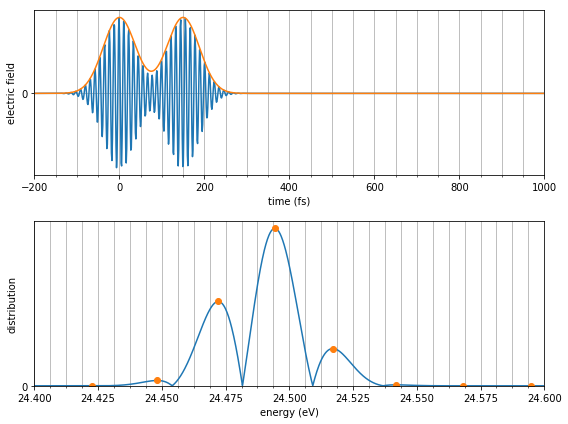

In [83]:
params = {
    'tfr': in_femto_sec(-200),  # fs
    'tto': in_femto_sec(1000),  # fs
    'sigma': in_femto_sec(90) / (8*np.log(2))**0.5,  # fwhm of a pulse in fs
    'amp': 1,
    'k0': in_electron_volt(24.49),  # eV
    'kfr': in_electron_volt(24.4),  # fs
    'kto': in_electron_volt(24.6),  # fs
    'dt': in_femto_sec(150),  # fs, 0 fs for single pulse, experimental limit is 200--600 fs (0.02--0.007 eV)
    'phi': in_degree(200),  # deg
}


def dist(k):
    return (
        # 1st term
        params['amp'] / 2j / params['sigma']
        * (1 + np.exp(-1j * (k * params['dt'] + params['phi'])))
        * gauss(k - params['k0'], 1 / params['sigma'])
        # # 2nd term (you can ignore it)
        # - params['amp'] / 2j / params['sigma']
        # * (1 + np.exp(-1j * (k * params['dt'] - params['phi'])))
        # * gauss(k + params['k0'], 1 / params['sigma'])
    )


t = np.linspace(params['tfr'], params['tto'], 1001)
k = np.linspace(params['kfr'], params['kto'], 1001)
absdist = np.abs(dist(k))
diff = np.gradient(absdist) > 0
where = diff[:-1] & ~diff[1:]

print("""\
Local maximums at:
    diff: {:6.3f} eV
    {}""".format(
        to_electron_volt(2*np.pi/params['dt']),
        "\n    ".join(f"{i:>4d}: {v:6.3f} eV" for i, v in enumerate(to_electron_volt(k[1:][where]))),
    )
)

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.xlabel('time (fs)')
plt.ylabel('electric field')
plt.plot(
    to_femto_sec(t),
    params['amp'] * np.sin(params['k0']*t) * gauss(t, params['sigma'])
    + params['amp'] * np.sin(params['k0']*(t-params['dt'])-params['phi']) * gauss((t-params['dt']), params['sigma']),
)
plt.plot(
    to_femto_sec(t),
    params['amp'] * gauss(t, params['sigma'])
    + params['amp'] * gauss((t-params['dt']), params['sigma']),
)
plt.xlim(to_femto_sec(params['tfr']),
         to_femto_sec(params['tto']))
plt.yticks([0], [0])
plt.minorticks_on()
plt.grid(True, which='both')

plt.subplot(212)
plt.xlabel('energy (eV)')
plt.ylabel('distribution')
plt.plot(to_electron_volt(k), absdist)
plt.plot(to_electron_volt(k[1:][where]), absdist[1:][where], 'o')
plt.xlim(to_electron_volt(params['kfr']),
         to_electron_volt(params['kto']))
plt.ylim(0, None)
plt.yticks([0], [0])
plt.minorticks_on()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

Local maximums at:
       0:   -106 fs
       1:      6 fs
       2:    123 fs
       3:    278 fs
       4:    395 fs
       5:    507 fs
       6:    663 fs
       7:    784 fs
       8:    894 fs


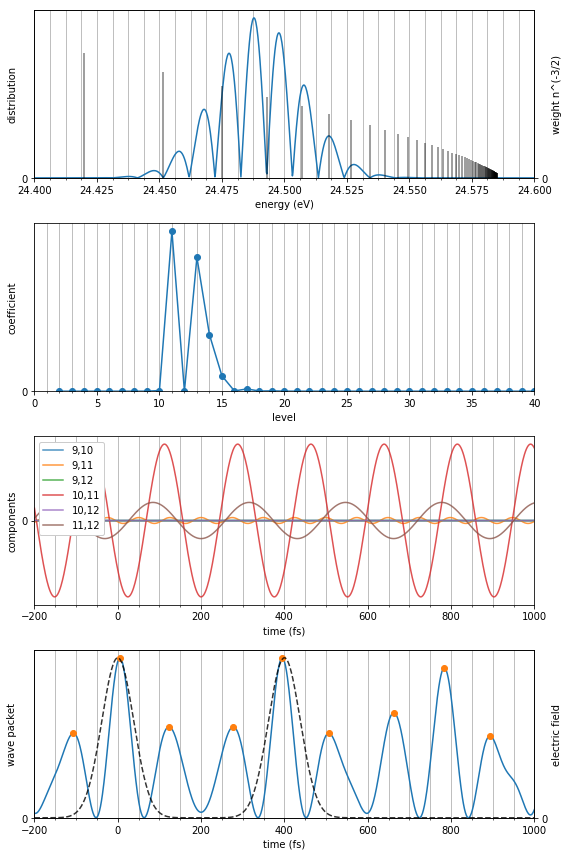

In [80]:
pop = df["n"] ** -1.5 * dist(df["level"])
waves = -1j * np.exp(1j * df["level"][:, None] * t[None, :]) * pop[:, None]
wavesqs = (waves[None, :, :] * waves[:, None, :].conj()).real
coeffs = wavesqs.sum((0,1))
diff = np.gradient(coeffs) > 0
where = diff[:-1] & ~diff[1:]

print("""\
Local maximums at:
    {}""".format(
        "\n    ".join(f"{i:>4d}: {v:6.0f} fs" for i, v in enumerate(to_femto_sec(t[1:][where]))),
    )
)

# fig1-1
plt.figure(figsize=(8,12))
plt.subplot(411)
plt.xlabel('energy (eV)')
plt.ylabel('distribution')
plt.plot(
    to_electron_volt(k),
    np.abs(dist(k)),
)
plt.xlim(to_electron_volt(params['kfr']),
         to_electron_volt(params['kto']))
plt.ylim(0, None)
plt.yticks([0], [0])
plt.minorticks_on()
plt.grid(True, which='both')

# fig1-2
plt.twinx()
plt.ylabel('weight n^(-3/2)')
plt.vlines(
    to_electron_volt(df['level'].values),
    0, df['n'].values ** -1.5,
    alpha=0.5,
)
plt.ylim(0, 0.05)
plt.yticks([0], [0])

# fig2
plt.subplot(412)
plt.xlabel("level")
plt.ylabel("coefficient")
plt.plot(df['n'], np.abs(pop), '-o')
plt.xlim(0, 40)
plt.ylim(0, None)
plt.yticks([0], [0])
plt.minorticks_on()
plt.grid(True, which='both')

# fig3
plt.subplot(413)
plt.xlabel("time (fs)")
plt.ylabel("components")
for (i, ni), (j, nj) in combinations(df['n'][df['n'].between(9, 12)].iteritems(), 2):
    plt.plot(
        to_femto_sec(t),
        wavesqs[i, j],
        alpha=0.8,
        label=f'{ni},{nj}',
    )
plt.xlim(to_femto_sec(params['tfr']),
         to_femto_sec(params['tto']))
plt.yticks([0], [0])
plt.minorticks_on()
plt.grid(True, which='both')
plt.legend(loc='upper left', framealpha=1, ncol=1)

# fig4-1
plt.subplot(414)
plt.xlabel("time (fs)")
plt.ylabel("wave packet")
plt.plot(to_femto_sec(t), coeffs)
plt.plot(to_femto_sec(t[1:][where]), coeffs[1:][where], 'o')
plt.xlim(to_femto_sec(params['tfr']),
         to_femto_sec(params['tto']))
plt.ylim(0, None)
plt.yticks([0], [0])
plt.minorticks_on()
plt.grid(True, which='both')

# fig4-2
plt.tight_layout()
plt.twinx()
plt.ylabel('electric field')
plt.plot(
    to_femto_sec(t),
    params['amp'] * gauss(t, params['sigma'])
    + params['amp'] * gauss((t-params['dt']), params['sigma']),
    'k--',
    alpha=0.8,
)
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()